# Neural Networks

So far, we considered models for regression and classification that comprised linear combinations of fixed basis functions. We saw that such models have useful analytical and computational properties but that their practical applicability was limited by the curse of dimensionality. In order to apply such models to large-scale and non-linear problems, it is necessary to adapt the basis functions to the data. Therefore, Neural Network is an alternative approach where we fix the number of basis functions in advance but allow them to be adaptive, in other words to use parametric forms for the basis functions in which the parameter values are adapted during training (learn from data). The price to
be paid for this more expressive model, is that the likelihood function which forms the basis for network training, is no longer a convex function of the model parameters which is harder to train. 

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st

# Reading, shuffling and preparing the data set
names = ['medv', 'crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat']
data = pd.read_csv('./data/regression-datasets-housing.csv', header=None, names=names)
data.drop('chas', axis=1, inplace=True)
data.reindex(np.random.permutation(data.index))
V = len(data.columns) - 1; N_tr =  int(np.ceil(len(data.index) * (0.75))); N_te = len(data.index) - N_tr;
mu = data.mean(); std = data.std(); data = (data - mu)/std;

# Split data set in training and testing
X_tr = data.values[:N_tr,1:]; Y_tr = data.values[:N_tr,0];
X_te = data.values[N_tr:,1:]; Y_te = data.values[N_tr:,0]; 
 
# add bias term to input
X_tr = np.concatenate((np.ones((X_tr.shape[0],1)),X_tr),axis=1)
X_te = np.concatenate((np.ones((X_te.shape[0],1)),X_te),axis=1)


# RMSE error
RMSE =  lambda y,t: np.sqrt(np.mean(np.power(y - t, 2)))


## Model

The Neural network can be seen as a linear model with adptative basis function. These basis functions can be combined in many depths and lenghts in order to build the Neural Network. However, I will work with multilayer perceptron of 3 layers (input, hidden and output). Thus, it can be represented as:

$$ y_k(x, w) = g\left( \sum^M_{j=0} w^{(2)}_{kj} h \left(  \sum^D_{i=0} w_{ji}^{(1)} x_i\right)  \right)$$

where $W_{kl}^{i}$ is the weight that conects neuron unit $l$ to unit $k$ in the $i$-layer. $M$ is the number of units in the hidden layer while $D$ is the number of inputs. $g$ and $h$ are the activation function of the hidden layer and the output layer, they should be differentiable. In all layer there is a bias that is automatically included in the weights and inputs like linear models. The most used activations are sigmoid(hidden unit and output units for binary classification), tangent hiperbolic (the same as sigmoid), sofmax(output units of multiclass problems) and identity(output units in regression problems).

In [5]:
# Model Parameters
D = V; M = 6; K = 1;
W1 = np.random.rand(D + 1, M)
W2 = np.random.rand(M + 1, K)
sigmoid = lambda x: 1 / (1 + np.exp(-x))
identity = lambda x: x

#add bias function
add_bias = lambda x: np.hstack((np.ones((x.shape[0], 1)), x))

#forward-pass function
feed_forward = lambda x, w1, w2: identity(np.dot(add_bias(sigmoid(np.dot(x, w1))), w2))

## Training

In addition to the definition of the network, we also should define wich loss function is going to be used for learning the adaptative parameters w. This decision depends on the problem type. 

Regression: The number of outputs is the number of target variables, $y(x_n,w)$ is the predicted value for the input $x_n$ and output units with identity activation function.
$$E(W) = \frac{1}{2} \sum_{n=1}^N (y(x_n,w)-t_n)^2$$
Binary Classification: Just one output what gives $y_n = P(C_1 \mid x)$ and $1 - y_n = P(C_2 \mid x_n)$ and has the sigmoid activation function
$$E(W) = - \sum_{n=1}^N(t_nln y_n + (1-t_n) ln(1-y_n))$$
K Binary independent Classification problem: K outputs which each one gives $y_{nk} = P(C_k\mid x_n)$ and has sigmoid activation function
$$E(W) = - \sum_{n=1}^N\sum_{k=1}^K(t_{nk}ln y_{nk} + (1-t_{nk}) ln(1-y_{nk}))$$
Multiclass classification problem with K mutually exclusive classes: K outputs which each one gives $y_{nk} = P(C_k\mid x_n)$, $t_n$ have 1-of K encoding and output units have softmax function. 
$$E(W) = - \sum_{n=1}^N\sum_{k=1}^K(t_{kn}ln y_{kn}))$$

### Error Backpropagations

For instance, let's work with 3 layers neural network for regressions where $E(W) = \hat{E}(W) + \hat{R}(W) = \frac{1}{2} \sum_k (y_{nk} - t_{nk})^2 + \frac{\lambda}{2} W^T W$, where $\hat{E}$ is the loss and $\hat{R}$ is the regularizer. In this case the regularizer is l2 and the loss is the sum-of-squares. We also have to define two basic equations related to the neural unit function: $z_j = h(a_j)$ and $a_j = \sum_i w_{ji} z_i$ where $z_j$ is the output of unit j and $z_i$ is the output of the units in the layer before the unit j. The function $h$ is the activation function of the unit, in this example it is the sigmoid function.

In order to adjust the weights W we need to compute the derivative $\frac{\partial E}{\partial w_{ij}}$ for all weights in the network. Thus we can split our derivative as follow,
$$\frac{\partial E}{\partial w_{ij}} = \frac{\partial \hat{E}}{\partial w_{ij}} + \frac{\partial \hat{R}}{\partial w_ij} = \frac{\partial \hat{E}}{\partial w_{ij}} + \lambda w_{ij}$$
As a result we just need to compute the derivatives in relation to $\hat{E}$, where we can apply the chain rule as follows,
$$ \frac{\partial \hat{E}}{\partial w_{ij}} = \frac{\partial \hat{E}}{\partial a_{j}} \frac{\partial a_j}{\partial w_{ij}} $$
this allowe we define the ''error'' in relation to a unit as $\delta_j = \frac{\partial \hat{E}}{\partial a_{j}}$. Using this error we can express our derivative as follow,
$$ \frac{\partial \hat{E}}{\partial w_{ij}} = \delta_j \frac{\partial a_j}{\partial w_{ij}} = \delta_j + \frac{\partial\sum_i w_{ji} z_i}{\partial w_{j_i}} = \delta_j z_i$$
Therefore, the required derivative is: 
$\frac{\partial E}{\partial w_{ij}} = \delta_j z_i + \lambda w_{ji}$. However, we still need to compute the error for the unit j, $\delta_j = \frac{\partial \hat{E}}{\partial a_{j}}$. We can start by units k's in the output layer, in the case of the sum-of-square erro is,
$$\delta_k = \frac{\partial \hat{E}}{\partial a_{k}} = y_k - t_k$$
then we can backpropagate the errors using the chain rule again, 

$$\delta_j = \frac{\partial \hat{E}}{\partial a_{j}} = \sum_k \frac{\partial \hat{E}}{\partial a_j} \frac{\partial a_k}{\partial a_j} = \sum_k \delta_k \frac{\partial \left( \sum_j w_{kj} h(a_j)\right)}{\partial a_j} = \sum_k \delta_k \left( w_{kj} h'(a_j)\right)$$

$$\delta_j =  h'(a_j) \sum_k \delta_k w_{kj}$$

In summary, the backpropagations is used to compute the derivative in order to adjust the weights of a nerual network as follows,


1. Apply an input vector $x_n$ to the network and forward propagate through the network using the model definition equation, in order to find the activations of all the hidden and output units.
2. Evaluate the $\delta_k = \frac{\partial E_n}{\partial a_{k}}$ for all the output units. 
3. Backpropagate the $\delta_k$’s to obtain $\delta_j = h'(a_j) \sum_K w_{kj}\delta_k$ for each hidden unit in the network.
4. Evaluate the required derivatives $\frac{\partial E_n}{\partial w_{ji}} = \delta_j z_i + \lambda w_{ji}$ for all weights.
5. Update weights $W(\tau + 1) = W(\tau) - \alpha \nabla E_n(W(\tau))$ 

Note: the same reasoning can be used for networks with different loss and activations functions, we just need to change some few equations results.


Training Root Squared Mean Error 0.31361335001334717
Testing Root Squared Mean Error 1.9821486156253916


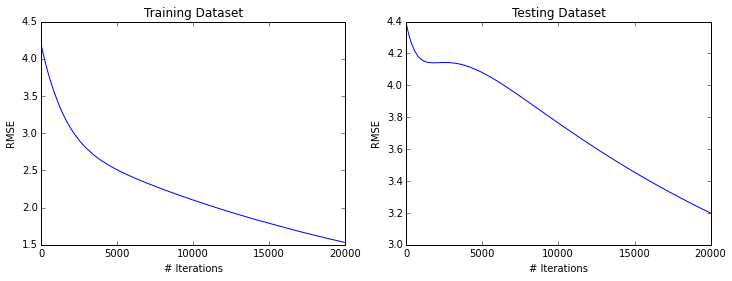

In [6]:
# Stochastic gradient descent, run through dataset
loss_tr = [];
loss_te = [];

# Init weights
W1 = np.random.rand(D + 1, M)
W2 = np.random.rand(M + 1, K)
alpha = 0.00001; lamb = 0.1; MAX_IT = 1000; batch_size = 20;

#shuffle data
ind = np.random.permutation(X_tr.shape[0]); X = X_tr.take(ind, axis=0); T = Y_tr.take(ind, axis=0);

for it in range(MAX_IT):
    for b in range(0, X.shape[0] + 1, batch_size):
    
        #get batch
        ind = range(b, min(b+batch_size, X.shape[0]));         
        X_b = X.take(ind, axis=0); T_b = T.take(ind, axis=0); 

        E2 = np.zeros_like(W2); E1 = np.zeros_like(W1);
        for x, t in zip(X_b, T_b):
            x = x.reshape((1,D + 1))

            # evaluate activations - forwards
            a_j = np.dot(x, W1); z_j = sigmoid(a_j);
            a_k = np.dot(add_bias(z_j), W2); z_k = identity(a_k);

            # evaluate errors - bckawards
            d_k = z_k - t;
            d_j = (z_j*(1 - z_j)) * np.dot(d_k, W2.T)[:,1:];        

            # Evaluate Gradients        
            E2 += np.dot(d_k.T, add_bias(z_j)).T + (lamb * W2)
            E1 += np.dot(d_j.T, x).T + (lamb * W1)            
    
        # Update weights with regularizer
        W1 = W1 - alpha * E1
        W2 = W2 - alpha * E2

        # Compute Errors - RMSE + L2 Regularization
        l2_reg = lamb * np.sum(np.power(W1,2)) + lamb * np.sum(np.power(W2,2))

        Tr = feed_forward(X_tr, W1, W2)
        loss_tr.append(RMSE(Tr,Y_tr) + l2_reg)  

        Te = feed_forward(X_te,W1, W2)
        loss_te.append(RMSE(Te,Y_te) + l2_reg) 

# plot errors
plt.figure(figsize=(12,4))
plt.subplot(1,2,1);plt.plot(loss_tr);plt.title('Training Dataset');plt.xlabel('# Iterations');plt.ylabel('RMSE')
plt.subplot(1,2,2);plt.plot(loss_te);plt.title('Testing Dataset');plt.xlabel('# Iterations');plt.ylabel('RMSE')
# Make predictions
Tr = feed_forward(X_tr, W1, W2)
print('Training Root Squared Mean Error {}'.format(RMSE(Tr,Y_tr)))
Te = feed_forward(X_te, W1, W2)
print('Testing Root Squared Mean Error {}'.format(RMSE(Te,Y_te)))

    